# Simple classification example with missing feature handling and parameter tuning

This tutorial will show you how to use CatBoost to train binary classifier for data with missing feature and how to do hyper-parameter tuning using Hyperopt framework.

Gaps in data may be a challenge to handle correctly, especially when they appear in categorical features, this tutorial will also give some advices how to handle them during model application.

In [1]:
!pip install -q numpy pandas catboost hyperopt scikit-learn frozendict matplotlib

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
import catboost as cb
import catboost.datasets as cbd
import catboost.utils as cbu
import numpy as np
import pandas as pd
import hyperopt
import sys

from frozendict import frozendict

# print module versions for reproducibility
print('CatBoost version {}'.format(cb.__version__))
print('NumPy version {}'.format(np.__version__))
print('Pandas version {}'.format(pd.__version__))
print('Hyperopt version {}'.format(hyperopt.__version__))

CatBoost version 0.12.0
NumPy version 1.15.4
Pandas version 0.23.4
Hyperopt version 0.2


In [4]:
# We are going to use UCI Adult Data Set because it has both numerical and categorical 
# features and also has missing features.
print(cbd.adult.__doc__)


    Download "Adult Data Set" [1] from UCI Machine Learning Repository.

    Will return two pandas.DataFrame-s, first with train part (adult.data) and second with test part
    (adult.test) of the dataset.

    [1]: https://archive.ics.uci.edu/ml/datasets/Adult
    


In [5]:
def get_fixed_adult():
    train, test = cbd.adult()
    
    # CatBoost doesn't support pandas.DataFrame missing values for categorical features out 
    # of the box (seed issue #571 on GitHub or issue MLTOOLS-2785 in internal tracker). So 
    # we have to replace them with some designated string manually. 
    for dataset in (train, test, ):
        for name in (name for name, dtype in dict(dataset.dtypes).items() if dtype == np.object):
            dataset[name].fillna('nan', inplace=True)
            
    # CatBoost doesn't support `class_names` in `Pool` c-tor (see MLTOOLS-2799 in internal 
    # tracker) so we have to convert them manually
    class_names = ('<=50K', '>50K', )
    for dataset in (train, test, ):
        dataset.income = dataset.income.map({'<=50K': 0., '>50K': 1.})
    
    X_train, y_train = train.drop('income', axis=1), train.income
    X_test, y_test = test.drop('income', axis=1), test.income
    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = get_fixed_adult()

In [7]:
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [8]:
X_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,nan,103497.0,Some-college,10.0,Never-married,nan,Own-child,White,Female,0.0,0.0,30.0,United-States


In [9]:
print('train: {}\ntest: {}'.format(y_train.value_counts(), y_test.value_counts()))

train: 0.0    24720
1.0     7841
Name: income, dtype: int64
test: 0.0    12435
1.0     3846
Name: income, dtype: int64


Ok, so our task here is to predict whether person makes over 50K per year. We'll use `CatBoostClassifier` to solve this problem. In CatBoost there are two possible objectives for binary classification: `Logloss` and `CrossEntropy`, we'll use the first one because second one works better with probabilities (while we have solid classes for each case).

We are also going to use [Hyperopt](https://github.com/hyperopt/hyperopt) for hyper-parameter optimization because it support optimization on a single host and is one of the most common solutions for hyper-parameter optimization. Though there is a number of other hyper-parameter optimization frameworks like [Chocolate](https://github.com/AIworx-Labs/chocolate) and [Skopt](https://scikit-optimize.github.io).

In [10]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()
        
        # we use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=20181224,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [11]:
def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'depth': hyperopt.hp.randint('depth', 7),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10)}
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=20181224))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != np.float)[0])
    
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [12]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = True
# number of iterations of hyper-parameter search
hyperopt_iterations = 30

const_params = frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 100,
    'random_seed': 20181224})

model, params = train_best_model(
    X_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)

best params are {u'task_type': u'CPU', u'random_seed': 20181224, u'eval_metric': u'AUC', u'learning_rate': 0.4234185321620083, u'depth': 5, u'loss_function': u'Logloss', u'iterations': 100, u'l2_leaf_reg': 9.464266235679002, u'custom_metric': [u'AUC']}


In [13]:
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    
    dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != np.float)[0])
    fpr, tpr, _ = cbu.get_roc_curve(model, dataset)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    pl.figure(figsize=(8, 8,))
    pl.plot(fpr, tpr)
    pl.xlim([-0.1, 1.1])
    pl.ylim([-0.1, 1.1])
    pl.xlabel('FPR')
    pl.ylabel('TPR')
    pl.title('ROC curve (AUC={:.3f})'.format(auc))
    pl.show()
    
    return auc

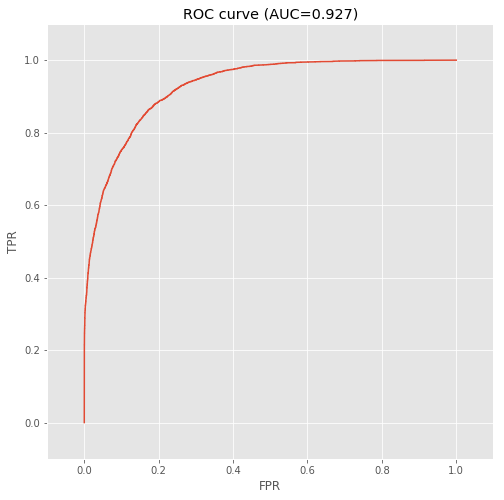

0.927486089391304

In [15]:
calculate_score_on_dataset_and_show_graph(X_test, y_test, model)